In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import open3d as o3d
from pathlib import Path
import zipfile
import requests
import os
import numpy as np
from contextlib import contextmanager
from framework.learner import Learner
from framework import callbacks
from tqdm import tqdm
from matplotlib import pyplot as plt


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
if not Path("ModelNet10").exists():
    req = requests.get(r"http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip")
    
    path = "ModelNet10.zip"

    with open(path, "wb") as f:
        f.write(req.content)

    with zipfile.ZipFile(path, "r") as f:
        f.extractall()

    os.remove(path)

## Dataloaders

In [3]:
class ModelNetDataSet(Dataset):
    def __init__(self, path: Path, number_of_points=1024, test=False):
        super(ModelNetDataSet, self).__init__()
        if isinstance(path, str):
            path = Path(path)

        self.number_of_points = number_of_points
        self.categories = [x.name for x in path.iterdir() if x.is_dir()]
        self.encoder = {x:i for i,x in enumerate(self.categories)}

        self.items = []
        for directory in path.iterdir():
            if not directory.is_dir(): continue

            item_dir = directory / "test" if test else directory / "train"

            for item in item_dir.glob("*.off"):
                self.items.append(item)



    def __getitem__(self, index):
        model_path = self.items[index]
        mesh = o3d.io.read_triangle_mesh(str(model_path))

        pc = torch.tensor(np.asarray(mesh.sample_points_uniformly(number_of_points=self.number_of_points).points).T)
        return pc, self.encoder[model_path.parent.parent.name]

    def __len__(self):
        return len(self.items)

            
    def visualise_random_samples(self, noise_level=0):
        # Initialize a figure with subplots
        fig = plt.figure(figsize=(17,10))
        
        # Randomly select 9 indices from the dataset
        sample_indices = torch.randperm(len(self))[:9]
        
        for i, index in enumerate(sample_indices):
            pc, category = self[index]
            
            # Reshape the point cloud data to (N, 3) shape
            pc = pc.numpy().T
            
            pc += (torch.randn(pc.shape)*(noise_level)**0.5).numpy()
            
            # Create a new Open3D point cloud object for visualization
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(pc)
            
            # Plot the point cloud using Open3D
            # o3d.visualization.draw_geometries([pcd], window_name=f'Sample {i + 1}')
            
            # Plot the point cloud using Matplotlib
            ax = fig.add_subplot(3, 3, i + 1, projection="3d")
            ax.set_title(f'Category: {list(self.encoder.keys())[category]}')
            ax.set_box_aspect((np.ptp(pc[:, 0]), np.ptp(pc[:, 1]), np.ptp(pc[:, 2])))
            ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=1)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
        
        plt.show()


    def visualise_batch(self):
        # TODO
        pass


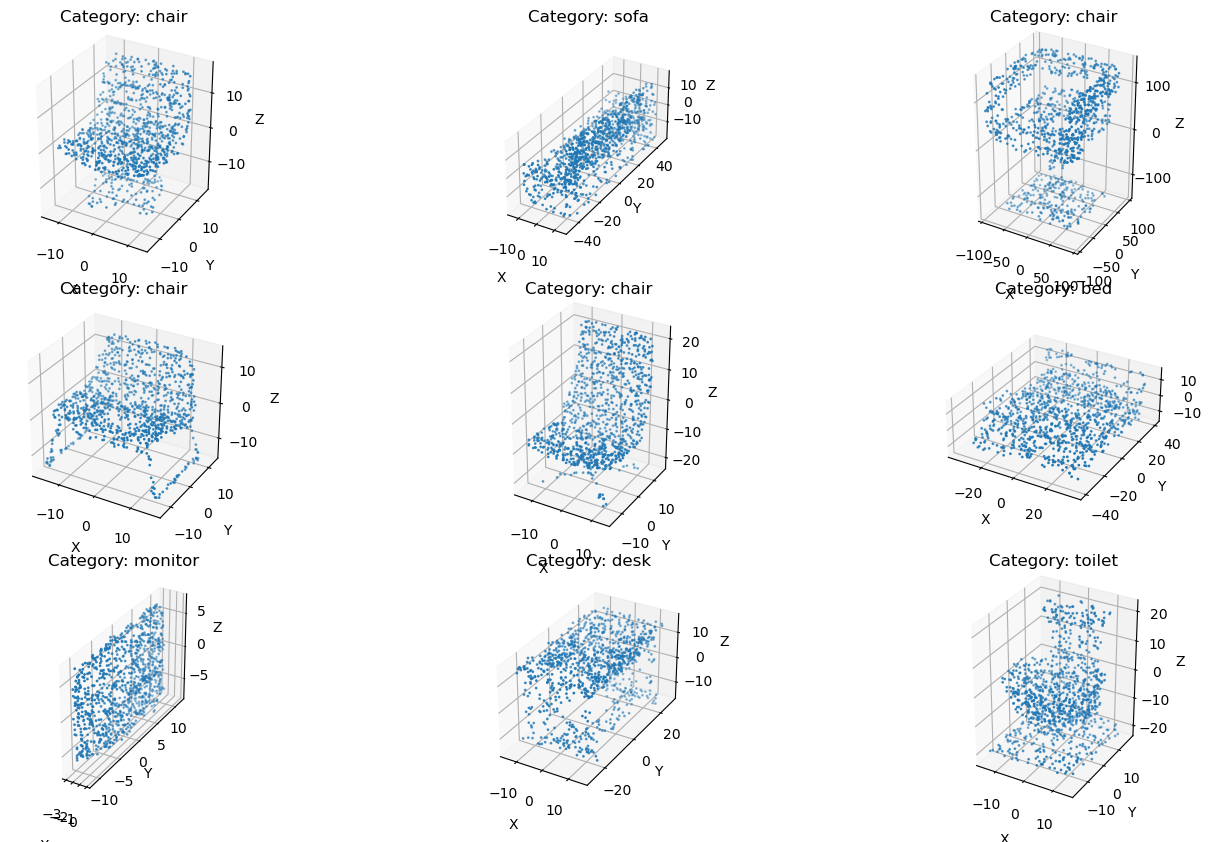

In [4]:

data = ModelNetDataSet("ModelNet10", test=False, number_of_points=1024)
len(data)
data.visualise_random_samples(0.05)

## Model

In [5]:
class TNet(nn.Module):

  def __init__(self, dim, device="cpu"):
    super(TNet, self).__init__()
    self.dim = dim

    self.conv_1 = nn.Conv1d(dim, 64, kernel_size=1)
    self.conv_2 = nn.Conv1d(64, 128, kernel_size=1)
    self.conv_3 = nn.Conv1d(128, 1024, kernel_size=1)

    self.linear_1 = nn.Linear(1024, 512)
    self.linear_2 = nn.Linear(512, 256)
    self.linear_3 = nn.Linear(256, dim*dim)

    self.bns = nn.ModuleList([nn.BatchNorm1d(x) for x in (64, 128, 1024, 512, 256)])

  def forward(self, x):
    # x.shape = [batch, dim, n]

    x = self.bns[0](F.relu(self.conv_1(x)))
    x = self.bns[1](F.relu(self.conv_2(x)))
    x = self.bns[2](F.relu(self.conv_3(x)))

    x = x.max(dim=2)[0]

    x = self.bns[3](F.relu(self.linear_1(x)))
    x = self.bns[4](F.relu(self.linear_2(x)))
    x = self.linear_3(x)

    # x.shape = [batch, self.dim**2]
    # Not sure if the requires grad is needed here
    identity = torch.eye(self.dim, requires_grad=True, device=x.device)

    return x.view(-1, self.dim, self.dim) + identity

In [6]:
class PointNetBackBone(nn.Module):
  def __init__(self, dims=(3, 64, 128, 1024), local_features=True):
    super(PointNetBackBone, self).__init__()

    self.dims = dims
    self.local_features = local_features

    self.tnet_1 = TNet(dims[0])
    self.tnet_2 = TNet(dims[1])

    self.conv_1 = nn.Conv1d(dims[0], dims[1], kernel_size=1, dtype=torch.float)
    self.conv_2 = nn.Conv1d(dims[1], dims[1], kernel_size=1, dtype=torch.float)

    self.conv_3 = nn.Conv1d(dims[1], dims[1], kernel_size=1, dtype=torch.float)
    self.conv_4 = nn.Conv1d(dims[1], dims[2], kernel_size=1, dtype=torch.float)
    self.conv_5 = nn.Conv1d(dims[2], dims[3], kernel_size=1, dtype=torch.float)

    self.bns = nn.ModuleList([nn.BatchNorm1d(x) for x in (dims[1], dims[1], dims[1], dims[2], dims[3])])

  def forward(self, x):
    # x.shape = [batch, dim_1, n]

    # transform.shape = [batch, dim_1, dim_1]
    transform = self.tnet_1(x)
    x = (transform[:, None]@x.transpose(1,2)[...,None]).squeeze().transpose(1,2)

    x = self.bns[0](F.relu(self.conv_1(x)))
    x = self.bns[1](F.relu(self.conv_2(x)))

    transform_2 = self.tnet_2(x)
    # (transform_2[:, None]@x[..., None]).shape = [batch, n, dim_2, dim_2]
    x = (transform_2[:, None]@x.transpose(1,2)[..., None]).squeeze().transpose(1,2)

    if self.local_features:
        # local_features.shape = [batch, n, dim_2]
        local_features = x.clone()

    x = self.bns[2](F.relu(self.conv_3(x)))
    x = self.bns[3](F.relu(self.conv_4(x)))
    x = self.bns[4](F.relu(self.conv_5(x)))

    # x.shape = [batch, n, 1024]
    global_features = x.max(dim=2)[0]

    if self.local_features:
        features = torch.cat((local_features, global_features[...,None].repeat(1,1,local_features.shape[-1])), dim=1)
        return features, transform, transform_2
    else:
        return global_features, transform, transform_2



In [7]:
class LinearUnit(nn.Module):
    """Some Information about LinearUnit"""
    def __init__(self, inputs, outputs, activation=F.relu, batchnorm=""):
        super(LinearUnit, self).__init__()
        
        self.linear = nn.Linear(inputs, outputs)
        self.batchnorm = batchnorm
        if batchnorm:
            self.batchnorm_layer = nn.BatchNorm1d(inputs)
        
        self.activation = activation

    def forward(self, x):

        if self.batchnorm == "pre":
            x = self.batchnorm_layer(x)

        x = self.linear(x)

        if self.activation is not None:
            x = self.activation(x)
        
        if self.batchnorm == "post":
            x = self.batchnorm_layer(x)

        return x

In [8]:
class PointNetClassificationHead(nn.Module):

    def __init__(self, outputs, layers, dims=None, keep=0.7):
        super(PointNetClassificationHead, self).__init__()

        if dims is None:
            self.backbone = PointNetBackBone(local_features=False)
            if layers[0] != 1024: raise ValueError(f"Dimensions don't match. {layers[0]} != 1024")
        else:
            self.backbone = PointNetBackBone(dims, False)
            if layers[0] != dims[-1]: raise ValueError(f"Dimensions don't match. {layers[0]} != {dims[-1]}")

        self.layers = nn.ModuleList([LinearUnit(x, y, batchnorm="pre") for x, y in zip(layers[:-2], layers[1:])])
        self.output = nn.Linear(layers[-2], layers[-1])
        self.dropout = nn.Dropout(p=1 - keep)


    def forward(self, x):
        x, t1, t2 = self.backbone(x)

        for layer in self.layers:
            x = layer(x)

        x = self.dropout(x)
        x = self.output(x)

        return F.log_softmax(x, dim=1), t1, t2

## Training

In [9]:
from framework.callback import Callback

class PrintCb(Callback):
    def after_validation(self, learner):
        preds = learner.predictions[0].max(dim=1)[1]
        acc = int((preds == learner.labels).sum())
        print(f"[{learner.epoch:03}/{learner.num_epochs}] Validation loss: {learner.loss.mean():.2f} \tNLL Loss: {F.nll_loss(learner.predictions[0], learner.labels):.2f} ({acc}/{learner.loss.shape[0]})")

    # def after_batch(self, learner):
    #     print(f"Batch loss: {learner.loss.mean()}")


class NumPointsVariation(Callback):

    def __init__(self, point_range, **kwargs):
        super(NumPointsVariation, self).__init__(**kwargs)
        self.point_range = point_range

    def before_batch(self, learner):
        a: torch.utils.data.DataLoader = learner.dataloaders["train"]
        a.dataset.number_of_points = torch.randint(*self.point_range, (1,))[0]

class PointCloudNoising(Callback):
    def __init__(self, noise_level, **kwargs):
        super(PointCloudNoising, self).__init__(**kwargs)
        # Variance
        self.noise_level = noise_level**0.5

    def before_batch(self, learner):
        learner.data += torch.randn(learner.data.shape, device=learner.data.device)*self.noise_level

class PointCloudTransform(Callback):
    def __init__(self, max_rotation, max_translation, **kwargs):
        super(PointCloudTransform, self).__init__(**kwargs)

        self.max_rotation = max_rotation
        self.max_translation = max_translation

    def before_batch(self, learner):
        # TODO
        rot = Rotation.from

        pass

class LRDecay(Callback):
    def __init__(self, epochs, factor, **kwargs):
        super(LRDecay, self).__init__(**kwargs)

        self.epochs = epochs
        self.factor = factor

    def after_epoch(self, learner):
        if learner.epoch and learner.epoch % self.factor == 0:
            for g in learner.optimiser.param_groups:
                g['lr'] *= self.factor

In [10]:
def loss_function(predictions, target, alpha=1E-3): 
    x, t1, t2 = predictions
    nll_loss = F.nll_loss(x, target, reduction="none")
    t1_loss = (torch.eye(t1.shape[-1])[None].to(t1.device) - t1@t1.transpose(1,2)).norm(p="fro", dim=(1,2))
    t2_loss = (torch.eye(t2.shape[-1])[None].to(t2.device) - t2@t2.transpose(1,2)).norm(p="fro", dim=(1,2))
    
    return nll_loss + t1_loss*alpha + t2_loss*alpha

In [11]:
train_dl = torch.utils.data.DataLoader(ModelNetDataSet("ModelNet10", test=True, number_of_points=1024), batch_size=32, shuffle=True)
val_dl = torch.utils.data.DataLoader(ModelNetDataSet("ModelNet10", test=True, number_of_points=1024), batch_size=32, shuffle=False)

In [12]:
model = PointNetClassificationHead(10, [1024, 512, 256, 10])
# Betas are momentum and momentum decay
# optimiser = torch.optim.Adam(model.parameters(), lr=1E-3, betas=[0.9, 0.999])
optimiser = torch.optim.SGD(model.parameters(), lr=1E-3, momentum=0.9)

learner = Learner(
    model.to("cuda"), 
    optimiser,
    loss_function, 
    {"train":train_dl, "validation":val_dl}, 
    [
        # callbacks.earlystopping.EarlyStoppingCallback("./model.pt", 20, 50), 
        PrintCb(),
        NumPointsVariation((1024, 8192)),
        PointCloudNoising(5E-2),
        LRDecay(20, 0.5)
    ]
)

In [13]:
learner.train(100)

[000/100] Validation loss: 7.18 	NLL Loss: 2.34 (0/908)
[001/100] Validation loss: 18.14 	NLL Loss: 6.07 (0/908)
[002/100] Validation loss: 108.78 	NLL Loss: 37.13 (0/908)
[003/100] Validation loss: 369.33 	NLL Loss: 42.94 (0/908)
[004/100] Validation loss: 536.86 	NLL Loss: 39.05 (0/908)
[005/100] Validation loss: 697.41 	NLL Loss: 64.86 (0/908)
[006/100] Validation loss: 604.29 	NLL Loss: 45.66 (0/908)
[007/100] Validation loss: 553.36 	NLL Loss: 72.65 (0/908)
[008/100] Validation loss: 691.17 	NLL Loss: 78.45 (0/908)
[009/100] Validation loss: 735.01 	NLL Loss: 88.98 (0/908)
[010/100] Validation loss: 632.95 	NLL Loss: 65.15 (0/908)
[011/100] Validation loss: 754.38 	NLL Loss: 67.50 (0/908)
[012/100] Validation loss: 630.40 	NLL Loss: 67.05 (0/908)
[013/100] Validation loss: 697.63 	NLL Loss: 53.10 (0/908)
[014/100] Validation loss: 723.73 	NLL Loss: 76.00 (0/908)
[015/100] Validation loss: 775.29 	NLL Loss: 72.38 (0/908)
[016/100] Validation loss: 739.69 	NLL Loss: 55.77 (0/908)
[0